# Phase 5e: Ensemble Voting Model
## XGBoost (60%) + LSTM (40%) Weighted Probability Ensemble

Combines XGBoost and LSTM predictions using weighted probability averaging for better RUL prediction accuracy.

## 1. Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, fbeta_score, roc_auc_score,
    precision_score, recall_score
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

data_dir = Path('../data')
models_dir = data_dir / 'models'
processed_dir = data_dir / 'processed'

print("✅ Imports successful")


✅ Imports successful


## 2. Load & Recreate Test Sequences

In [2]:
df = pd.read_csv(processed_dir / 'train_features_FD001.csv')

# Load exact feature orders used during training
with open(models_dir / 'feature_names.json', 'r') as f:
    xgb_feature_data = json.load(f)
    xgb_features = xgb_feature_data['features']

with open(models_dir / 'lstm_features.json', 'r') as f:
    lstm_feature_data = json.load(f)
    lstm_features = lstm_feature_data['features']

print(f"✅ Data loaded: {df.shape}")
print(f"✅ XGBoost features: {len(xgb_features)} (from feature_names.json)")
print(f"✅ LSTM features: {len(lstm_features)} (from lstm_features.json)")


✅ Data loaded: (20631, 128)
✅ XGBoost features: 124 (from feature_names.json)
✅ LSTM features: 40 (from lstm_features.json)


In [3]:
def create_sequences(df, feature_cols, sequence_length=30):
    X_seq, y_seq, engine_ids = [], [], []
    for engine_id in df['unit_id'].unique():
        engine_df = df[df['unit_id'] == engine_id]
        X = engine_df[feature_cols].values
        y = engine_df['failure_soon'].values
        for i in range(len(X) - sequence_length + 1):
            X_seq.append(X[i:i + sequence_length, :])
            y_seq.append(y[i + sequence_length - 1])
            engine_ids.append(engine_id)
    return np.array(X_seq), np.array(y_seq), np.array(engine_ids)

# Create sequences with 30-cycle window using ALL features (for XGBoost)
# LSTM will use subset of features during prediction
X_seq, y_seq, engine_ids_seq = create_sequences(df, xgb_features, 30)
print(f"✅ Sequences created: {X_seq.shape} (all features for compatibility)")

✅ Sequences created: (17731, 30, 124) (all features for compatibility)


In [4]:
unique_engines = df['unit_id'].unique()
n_engines = len(unique_engines)
n_train = int(0.70 * n_engines)
n_val = int(0.15 * n_engines)

train_engines = np.sort(unique_engines[:n_train])
val_engines = np.sort(unique_engines[n_train:n_train + n_val])
test_engines = np.sort(unique_engines[n_train + n_val:])

train_mask = np.isin(engine_ids_seq, train_engines)
val_mask = np.isin(engine_ids_seq, val_engines)
test_mask = np.isin(engine_ids_seq, test_engines)

X_val_seq = X_seq[val_mask]
y_val_seq = y_seq[val_mask]
X_test_seq = X_seq[test_mask]
y_test_seq = y_seq[test_mask]

print("✅ Train/Val/Test split completed")
print(f"   Val:  {X_val_seq.shape} (Failures: {y_val_seq.sum()})")
print(f"   Test: {X_test_seq.shape} (Failures: {y_test_seq.sum()})")

✅ Train/Val/Test split completed
   Val:  (2775, 30, 124) (Failures: 465)
   Test: (2856, 30, 124) (Failures: 465)


In [5]:
# Prepare XGBoost inputs (must match training-time scaling)
import joblib

xgb_scaler = joblib.load(models_dir / 'scaler.pkl')
X_val_flat_raw = X_val_seq[:, -1, :]
X_test_flat_raw = X_test_seq[:, -1, :]
X_val_flat = xgb_scaler.transform(X_val_flat_raw)
X_test_flat = xgb_scaler.transform(X_test_flat_raw)

# Prepare LSTM inputs (scaled only on LSTM features)
lstm_feature_indices = [xgb_features.index(f) for f in lstm_features]
X_train_seq_lstm = X_seq[train_mask][:, :, lstm_feature_indices]
X_val_seq_lstm = X_val_seq[:, :, lstm_feature_indices]
X_test_seq_lstm = X_test_seq[:, :, lstm_feature_indices]

n_train, n_time, n_feat = X_train_seq_lstm.shape
X_train_reshaped = X_train_seq_lstm.reshape(-1, n_feat)
X_val_reshaped = X_val_seq_lstm.reshape(-1, n_feat)
X_test_reshaped = X_test_seq_lstm.reshape(-1, n_feat)

try:
    lstm_scaler = joblib.load(models_dir / 'lstm_scaler.pkl')
    X_val_seq_lstm_scaled = lstm_scaler.transform(X_val_reshaped).reshape(X_val_seq_lstm.shape)
    X_test_seq_lstm_scaled = lstm_scaler.transform(X_test_reshaped).reshape(X_test_seq_lstm.shape)
    print('✅ Loaded LSTM scaler from lstm_scaler.pkl')
except Exception:
    lstm_scaler = StandardScaler()
    lstm_scaler.fit(X_train_reshaped)
    X_val_seq_lstm_scaled = lstm_scaler.transform(X_val_reshaped).reshape(X_val_seq_lstm.shape)
    X_test_seq_lstm_scaled = lstm_scaler.transform(X_test_reshaped).reshape(X_test_seq_lstm.shape)
    print('✅ Fitted new LSTM scaler from training data')

print('✅ Loaded XGBoost scaler from scaler.pkl')
print(f'✅ X_val_flat: {X_val_flat.shape}')
print(f'✅ X_test_flat: {X_test_flat.shape}')
print(f'✅ X_val_seq_lstm_scaled: {X_val_seq_lstm_scaled.shape}')
print(f'✅ X_test_seq_lstm_scaled: {X_test_seq_lstm_scaled.shape}')


✅ Loaded LSTM scaler from lstm_scaler.pkl
✅ Loaded XGBoost scaler from scaler.pkl
✅ X_val_flat: (2775, 124)
✅ X_test_flat: (2856, 124)
✅ X_val_seq_lstm_scaled: (2775, 30, 40)
✅ X_test_seq_lstm_scaled: (2856, 30, 40)


## 3. Load Models

In [6]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(str(models_dir / 'xgboost_baseline.json'))

lstm_model = keras.models.load_model(str(models_dir / 'lstm_temporal.h5'))

with open(models_dir / 'xgboost_baseline_metrics.json', 'r') as f:
    xgb_metrics_all = json.load(f)
    xgb_metrics = xgb_metrics_all['test_metrics']
    xgb_metrics['test_f2'] = xgb_metrics['f2_score']
    xgb_metrics['test_precision'] = xgb_metrics['precision']
    xgb_metrics['test_recall'] = xgb_metrics['recall']
    xgb_metrics['test_roc_auc'] = xgb_metrics['roc_auc']
    xgb_val_f2_ref = float(xgb_metrics_all['validation_metrics']['f2_score'])

with open(models_dir / 'lstm_temporal_metrics.json', 'r') as f:
    lstm_metrics_all = json.load(f)
    lstm_metrics = lstm_metrics_all['test_metrics']
    lstm_metrics['test_f2'] = lstm_metrics['f2_score']
    lstm_metrics['test_precision'] = lstm_metrics['precision']
    lstm_metrics['test_recall'] = lstm_metrics['recall']
    lstm_metrics['test_roc_auc'] = lstm_metrics['roc_auc']
    lstm_val_f2_ref = float(lstm_metrics_all['validation_metrics']['f2_score'])

print('✅ Models loaded')
print(f"   XGBoost F2 (test): {xgb_metrics['test_f2']:.4f}")
print(f"   LSTM F2 (test): {lstm_metrics['test_f2']:.4f}")
print(f"   XGBoost F2 (val reference): {xgb_val_f2_ref:.4f}")
print(f"   LSTM F2 (val reference): {lstm_val_f2_ref:.4f}")


✅ Models loaded
   XGBoost F2 (test): 0.9923
   LSTM F2 (test): 0.8637
   XGBoost F2 (val reference): 0.9983
   LSTM F2 (val reference): 0.8943


## 4. Generate Predictions

In [7]:
# XGBoost predictions (uses all 124 features, raw values)
xgb_pred_proba_val_raw = xgb_model.predict_proba(X_val_flat)[:, 1]
xgb_pred_proba_test_raw = xgb_model.predict_proba(X_test_flat)[:, 1]

# LSTM predictions (scaled LSTM feature subset)
lstm_pred_proba_val_raw = lstm_model.predict(X_val_seq_lstm_scaled, verbose=0).flatten()
lstm_pred_proba_test_raw = lstm_model.predict(X_test_seq_lstm_scaled, verbose=0).flatten()

# Probability calibration (Platt scaling) on validation split
# We keep both raw and calibrated variants, and pick whichever performs better on val F2.
def platt_scale(val_proba, y_val, test_proba):
    val_proba = np.clip(val_proba, 1e-6, 1 - 1e-6)
    test_proba = np.clip(test_proba, 1e-6, 1 - 1e-6)
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(val_proba.reshape(-1, 1), y_val)
    val_cal = clf.predict_proba(val_proba.reshape(-1, 1))[:, 1]
    test_cal = clf.predict_proba(test_proba.reshape(-1, 1))[:, 1]
    return val_cal, test_cal

xgb_pred_proba_val_cal, xgb_pred_proba_test_cal = platt_scale(xgb_pred_proba_val_raw, y_val_seq, xgb_pred_proba_test_raw)
lstm_pred_proba_val_cal, lstm_pred_proba_test_cal = platt_scale(lstm_pred_proba_val_raw, y_val_seq, lstm_pred_proba_test_raw)

print('✅ Predictions generated (val + test)')
print('✅ Raw + Platt-calibrated probabilities prepared')


✅ Predictions generated (val + test)
✅ Raw + Platt-calibrated probabilities prepared


## 5. Weighted Ensemble (60% XGBoost + 40% LSTM)

In [8]:
# Utility: best threshold for F2 on validation
def best_f2_threshold(y_true, probas, beta=2):
    thresholds = np.linspace(0.05, 0.95, 181)
    best_t, best_score = 0.5, -1.0
    for t in thresholds:
        pred = (probas >= t).astype(int)
        s = fbeta_score(y_true, pred, beta=beta)
        if s > best_score:
            best_score = s
            best_t = t
    return best_t, best_score

# Pick best probability variant (raw vs calibrated) for each base model by val F2
xgb_t_raw, xgb_f2_raw = best_f2_threshold(y_val_seq, xgb_pred_proba_val_raw, beta=2)
xgb_t_cal, xgb_f2_cal = best_f2_threshold(y_val_seq, xgb_pred_proba_val_cal, beta=2)
if xgb_f2_cal > xgb_f2_raw:
    xgb_variant = 'calibrated'
    xgb_pred_proba_val = xgb_pred_proba_val_cal
    xgb_pred_proba_test = xgb_pred_proba_test_cal
    xgb_best_threshold_val = xgb_t_cal
    xgb_best_f2_val = xgb_f2_cal
else:
    xgb_variant = 'raw'
    xgb_pred_proba_val = xgb_pred_proba_val_raw
    xgb_pred_proba_test = xgb_pred_proba_test_raw
    xgb_best_threshold_val = xgb_t_raw
    xgb_best_f2_val = xgb_f2_raw

lstm_t_raw, lstm_f2_raw = best_f2_threshold(y_val_seq, lstm_pred_proba_val_raw, beta=2)
lstm_t_cal, lstm_f2_cal = best_f2_threshold(y_val_seq, lstm_pred_proba_val_cal, beta=2)
if lstm_f2_cal > lstm_f2_raw:
    lstm_variant = 'calibrated'
    lstm_pred_proba_val = lstm_pred_proba_val_cal
    lstm_pred_proba_test = lstm_pred_proba_test_cal
else:
    lstm_variant = 'raw'
    lstm_pred_proba_val = lstm_pred_proba_val_raw
    lstm_pred_proba_test = lstm_pred_proba_test_raw

# Baseline (XGBoost-only) tuned on validation for reporting
xgb_pred_test_tuned = (xgb_pred_proba_test >= xgb_best_threshold_val).astype(int)
xgb_f2_test_tuned = fbeta_score(y_test_seq, xgb_pred_test_tuned, beta=2)

# Ensemble search: learn blend weight on validation
weights = np.linspace(0.0, 1.0, 41)  # xgb weight, lstm weight = 1 - xgb
best_weight = 0.6
best_threshold = 0.5
best_ensemble_f2_val = -1.0
best_ensemble_proba_test = None

for w in weights:
    val_proba = (w * xgb_pred_proba_val) + ((1.0 - w) * lstm_pred_proba_val)
    test_proba = (w * xgb_pred_proba_test) + ((1.0 - w) * lstm_pred_proba_test)
    t, score = best_f2_threshold(y_val_seq, val_proba, beta=2)
    if score > best_ensemble_f2_val:
        best_ensemble_f2_val = score
        best_threshold = t
        best_weight = w
        best_ensemble_proba_test = test_proba

# Evaluate best ensemble on test
ensemble_pred_test = (best_ensemble_proba_test >= best_threshold).astype(int)
ensemble_f2 = fbeta_score(y_test_seq, ensemble_pred_test, beta=2)
ensemble_precision = precision_score(y_test_seq, ensemble_pred_test)
ensemble_recall = recall_score(y_test_seq, ensemble_pred_test)
ensemble_roc_auc = roc_auc_score(y_test_seq, best_ensemble_proba_test)

# Production fallback rule (against saved XGBoost validation reference)
min_f2_gain = 0.005
use_ensemble = best_ensemble_f2_val >= (xgb_val_f2_ref + min_f2_gain)
if use_ensemble:
    selected_model = 'ensemble'
    selected_pred = ensemble_pred_test
    selected_proba = best_ensemble_proba_test
    selected_threshold = best_threshold
    selected_f2 = ensemble_f2
    selected_precision = ensemble_precision
    selected_recall = ensemble_recall
    selected_roc_auc = ensemble_roc_auc
else:
    selected_model = 'xgboost'
    selected_pred = xgb_pred_test_tuned
    selected_proba = xgb_pred_proba_test
    selected_threshold = xgb_best_threshold_val
    selected_f2 = xgb_f2_test_tuned
    selected_precision = precision_score(y_test_seq, selected_pred)
    selected_recall = recall_score(y_test_seq, selected_pred)
    selected_roc_auc = roc_auc_score(y_test_seq, selected_proba)

print()
print('📊 ENSEMBLE SEARCH + FALLBACK RESULTS')
print('='*60)
print(f'XGB probability variant:        {xgb_variant} (val F2={xgb_best_f2_val:.4f}, t={xgb_best_threshold_val:.2f})')
print(f'LSTM probability variant:       {lstm_variant}')
print(f'Best blend weight (xgb/lstm):   {best_weight:.2f}/{1-best_weight:.2f}')
print(f'Best ensemble threshold (val):  {best_threshold:.2f}')
print(f'Best ensemble Val F2:           {best_ensemble_f2_val:.4f}')
print(f'XGBoost Val F2 reference:       {xgb_val_f2_ref:.4f}')
print(f'Min gain required:              {min_f2_gain:.3f}')
print('-')
print(f'Selected production model:      {selected_model}')
print(f'Selected Test F2:               {selected_f2:.4f}')
print(f'Selected Test Precision:        {selected_precision:.4f}')
print(f'Selected Test Recall:           {selected_recall:.4f}')
print(f'Selected Test ROC-AUC:          {selected_roc_auc:.4f}')
print('='*60)



📊 ENSEMBLE SEARCH + FALLBACK RESULTS
XGB probability variant:        raw (val F2=0.9983, t=0.46)
LSTM probability variant:       raw
Best blend weight (xgb/lstm):   0.78/0.22
Best ensemble threshold (val):  0.54
Best ensemble Val F2:           0.9983
XGBoost Val F2 reference:       0.9983
Min gain required:              0.005
-
Selected production model:      xgboost
Selected Test F2:               0.9915
Selected Test Precision:        0.9667
Selected Test Recall:           0.9978
Selected Test ROC-AUC:          0.9999


## 6. Confusion Matrix

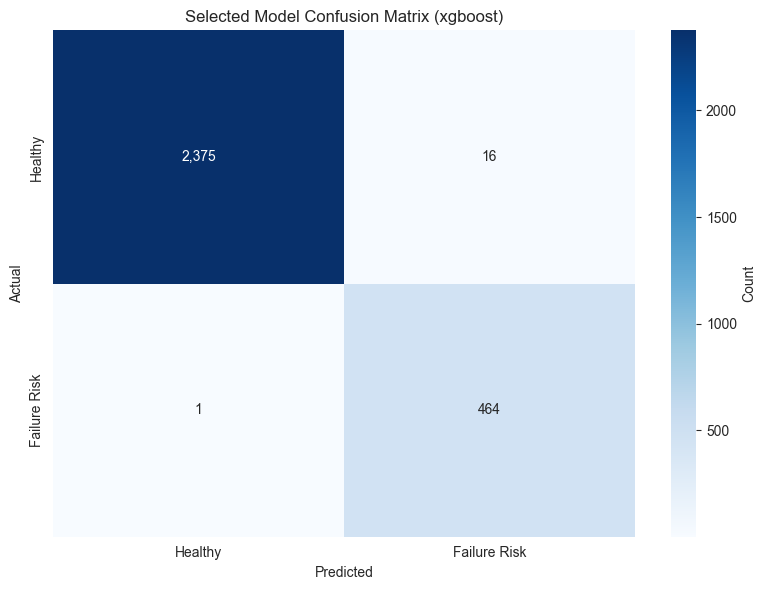

TN: 2375  FP: 16
FN: 1  TP: 464


In [9]:
cm = confusion_matrix(y_test_seq, selected_pred)
tn, fp, fn, tp = cm.ravel()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Selected Model Confusion Matrix ({selected_model})')
ax.set_xticklabels(['Healthy', 'Failure Risk'])
ax.set_yticklabels(['Healthy', 'Failure Risk'])
plt.tight_layout()
plt.show()

print(f"TN: {tn}  FP: {fp}")
print(f"FN: {fn}  TP: {tp}")


## 7. Model Comparison


📈 THREE-MODEL COMPARISON
           XGBoost    LSTM  Ensemble
F2          0.9923  0.8637    0.9932
Precision   0.9707  0.8520    0.9748
Recall      0.9978  0.8667    0.9978
ROC-AUC     0.9999  0.9869    0.9993


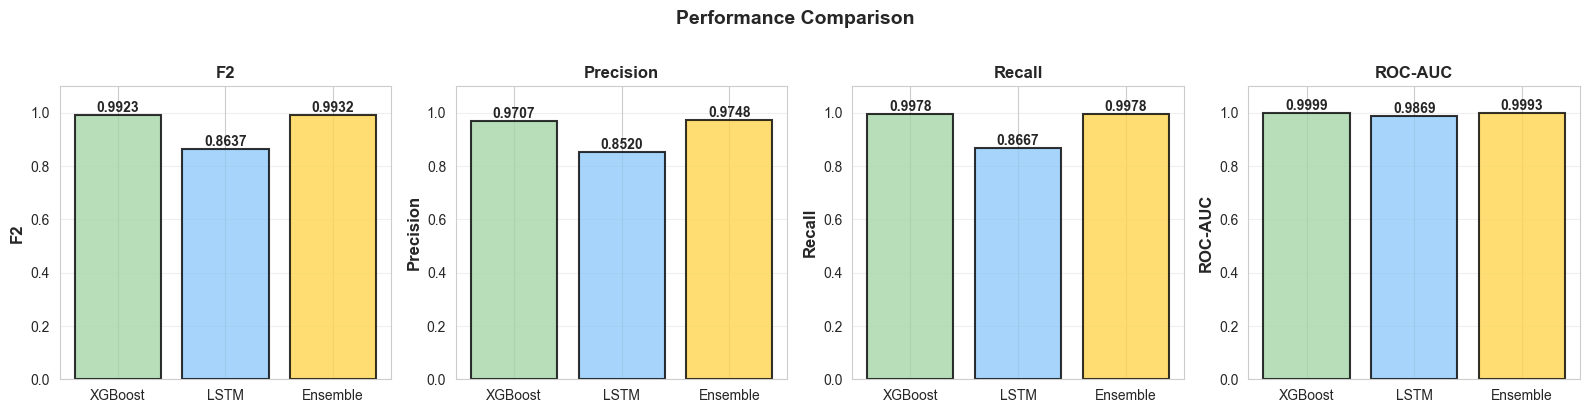

In [10]:
comparison = pd.DataFrame({
    'XGBoost': {'F2': xgb_metrics['test_f2'], 'Precision': xgb_metrics['test_precision'], 
                'Recall': xgb_metrics['test_recall'], 'ROC-AUC': xgb_metrics['test_roc_auc']},
    'LSTM': {'F2': lstm_metrics['test_f2'], 'Precision': lstm_metrics['test_precision'],
             'Recall': lstm_metrics['test_recall'], 'ROC-AUC': lstm_metrics['test_roc_auc']},
    'Ensemble': {'F2': ensemble_f2, 'Precision': ensemble_precision,
                 'Recall': ensemble_recall, 'ROC-AUC': ensemble_roc_auc}
})

print("\n📈 THREE-MODEL COMPARISON")
print(comparison.round(4))

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, metric in enumerate(['F2', 'Precision', 'Recall', 'ROC-AUC']):
    ax = axes[idx]
    values = [comparison[model][metric] for model in comparison.columns]
    colors = ['#A5D6A7', '#90CAF9', '#FFD54F']
    bars = ax.bar(comparison.columns, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    ax.set_title(metric, fontsize=12, fontweight='bold')
plt.suptitle('Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Save Results

In [11]:
ensemble_metrics = {
    'model': 'Weighted Ensemble (validation-tuned)',
    'calibration': 'platt_optional',
    'xgb_probability_variant': xgb_variant,
    'lstm_probability_variant': lstm_variant,
    'weights': {'xgboost': float(best_weight), 'lstm': float(1.0 - best_weight)},
    'best_threshold_val': float(best_threshold),
    'val_f2_ensemble_best': float(best_ensemble_f2_val),
    'xgb_best_threshold_val': float(xgb_best_threshold_val),
    'xgb_best_f2_val_current_split': float(xgb_best_f2_val),
    'xgb_val_f2_reference': float(xgb_val_f2_ref),
    'min_f2_gain_for_ensemble': float(min_f2_gain),
    'selected_model': selected_model,
    'selected_threshold': float(selected_threshold),
    'test_f2': float(selected_f2),
    'test_precision': float(selected_precision),
    'test_recall': float(selected_recall),
    'test_roc_auc': float(selected_roc_auc),
    'ensemble_test_f2': float(ensemble_f2),
    'ensemble_test_precision': float(ensemble_precision),
    'ensemble_test_recall': float(ensemble_recall),
    'ensemble_test_roc_auc': float(ensemble_roc_auc),
    'confusion_matrix': {'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
}

with open(models_dir / 'ensemble_metrics.json', 'w') as f:
    json.dump(ensemble_metrics, f, indent=2)

print('✅ Ensemble metrics saved')


✅ Ensemble metrics saved


In [12]:
print()
print('='*60)
print('PHASE 5e COMPLETE: ENSEMBLE VOTING')
print('='*60)
print(f'Best blend discovered (val): XGB {best_weight:.2f} + LSTM {1-best_weight:.2f}')
print(f'Selected production model: {selected_model}')
print(f'Selected Test F2: {selected_f2:.4f}')
print('Artifact: data/models/ensemble_metrics.json')
print('='*60)




PHASE 5e COMPLETE: ENSEMBLE VOTING
Best blend discovered (val): XGB 0.78 + LSTM 0.22
Selected production model: xgboost
Selected Test F2: 0.9915
Artifact: data/models/ensemble_metrics.json
